In [ ]:
!unzip /content/drive/MyDrive/CarDamage/doors.zip -d /content/

Archive:  /content/drive/MyDrive/CarDamage/doors.zip
   creating: /content/train/
   creating: /content/train/half/
  inflating: /content/train/half/1045_0_png.rf.2659182a89f46d0fc80d3db5dc089899.jpg  
  inflating: /content/train/half/1045_0_png.rf.5887ec9a6b674a22afb558bcb4fbd143.jpg  
  inflating: /content/train/half/1045_0_png.rf.a541f87e05b071860a9c83f0d927c6f4.jpg  
  inflating: /content/train/half/1047_0_png.rf.11c834d493b82d2daaca43d45e08f6ee.jpg  
  inflating: /content/train/half/1047_0_png.rf.727c4d68c6f48a92c7a1c7e6db02c850.jpg  
  inflating: /content/train/half/1047_0_png.rf.c581379cb5defd068425f3f88372d84d.jpg  
  inflating: /content/train/half/1070_0_png.rf.9d3eef207e4614220782d6e8d0189a8a.jpg  
  inflating: /content/train/half/1070_0_png.rf.d7da885fe3c58eef586673cb0c743bad.jpg  
  inflating: /content/train/half/1070_0_png.rf.f4d41e8e5b42f721b673461a24d9089c.jpg  
  inflating: /content/train/half/1114_0_png.rf.101e95d65ef7c405596dfa05297e0631.jpg  
  inflating: /content/tr

In [ ]:
!pip install torch torchvision transformers ultralytics scikit-learn matplotlib seaborn pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 138.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time

# Verificar disponibilidade de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Configurações
BATCH_SIZE = 32
MAX_EPOCHS = 40
LEARNING_RATE = 0.001
PATIENCE = 10  # Número de épocas para esperar melhoria antes de parar

# Dataset personalizado
class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Função para carregar e preparar os dados
def load_data(data_dir):
    # Transformações para os dados
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Carrega o dataset completo
    full_dataset = ImageClassificationDataset(data_dir, transform=data_transforms)

    # Divide em treino e validação (80% / 20%)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Cria os dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, val_loader, full_dataset.classes

# Função para treinar o modelo com early stopping
def train_resnet(model, criterion, optimizer, train_loader, val_loader, patience=5, max_epochs=30):
    best_val_acc = 0.0
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    start_time = time.time()

    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 10)

        # Fase de treino
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Fase de validação
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.double() / len(val_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0

            # Salvar o melhor modelo
            torch.save(model.state_dict(), 'best_resnet_model.pth')
            print(f"Modelo salvo com acurácia de validação: {val_acc:.4f}")
        else:
            epochs_no_improve += 1
            print(f"Sem melhoria por {epochs_no_improve} épocas")

        if epochs_no_improve >= patience:
            print(f"Early stopping ativado após {epoch+1} épocas")
            break

    time_elapsed = time.time() - start_time
    print(f'Treinamento completado em {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Melhor precisão de validação: {best_val_acc:.4f}')

    # Carregar o melhor modelo
    model.load_state_dict(torch.load('best_resnet_model.pth'))

    return model, history

# Função para avaliar o modelo
def evaluate_resnet(model, data_loader, criterion, classes):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)

    print(f'Avaliação - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Métricas adicionais
    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    print("\nClassification Report:")
    print(report)

    # Matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão - ResNet')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.savefig('resnet_confusion_matrix.png')
    plt.close()

    return epoch_acc.item(), report, cm

# Função para plotar curvas de treinamento
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Gráfico de perda
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title('Loss Durante Treinamento')
    plt.ylabel('Loss')
    plt.xlabel('Época')
    plt.legend()

    # Gráfico de acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Treinamento')
    plt.plot(history['val_acc'], label='Validação')
    plt.title('Acurácia Durante Treinamento')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend()

    plt.tight_layout()
    plt.savefig('resnet_training_curves.png')
    plt.close()

# Função principal
def main(data_dir):
    print(f"Carregando dados de: {data_dir}")

    # Carregar dados
    train_loader, val_loader, classes = load_data(data_dir)
    num_classes = len(classes)

    print(f"Número de classes: {num_classes}")
    print(f"Classes: {classes}")

    # Inicializar modelo ResNet-50
    print("\nInicializando modelo ResNet-50...")
    model = models.resnet50(weights='DEFAULT')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(DEVICE)

    # Definir critério de perda e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Treinar modelo com early stopping
    print("\nIniciando treinamento...")
    model, history = train_resnet(
        model, criterion, optimizer,
        train_loader, val_loader,
        patience=PATIENCE, max_epochs=MAX_EPOCHS
    )

    # Avaliar modelo
    print("\nAvaliando modelo final...")
    acc, report, _ = evaluate_resnet(model, val_loader, criterion, classes)

    # Plotar curvas de treinamento
    plot_training_curves(history)

    # Salvar relatório final
    with open('resnet_report.txt', 'w') as f:
        f.write("=== Relatório de Treinamento da ResNet ===\n\n")
        f.write(f"Número de classes: {num_classes}\n")
        f.write(f"Classes: {classes}\n\n")
        f.write(f"Acurácia final: {acc:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)

    print("\nTreinamento e avaliação concluídos!")
    print(f"Melhor acurácia alcançada: {acc:.4f}")
    print("Gráficos e relatórios salvos.")

# Executar o programa
if __name__ == "__main__":
    # Substitua pelo caminho do seu diretório de imagens
    data_dir = "/content/train"
    main(data_dir)

Usando dispositivo: cuda
Carregando dados de: /content/train
Número de classes: 4
Classes: ['minor', 'half', 'without', 'very']

Inicializando modelo ResNet-50...

Iniciando treinamento...
Epoch 1/40
----------
Train Loss: 1.2281 Acc: 0.4501
Val Loss: 1.1751 Acc: 0.5255
Modelo salvo com acurácia de validação: 0.5255
Epoch 2/40
----------
Train Loss: 0.8662 Acc: 0.6650
Val Loss: 1.2563 Acc: 0.5714
Modelo salvo com acurácia de validação: 0.5714
Epoch 3/40
----------
Train Loss: 0.5874 Acc: 0.7980
Val Loss: 1.2338 Acc: 0.5255
Sem melhoria por 1 épocas
Epoch 4/40
----------
Train Loss: 0.4876 Acc: 0.8184
Val Loss: 1.3446 Acc: 0.5357
Sem melhoria por 2 épocas
Epoch 5/40
----------
Train Loss: 0.3178 Acc: 0.9015
Val Loss: 0.9346 Acc: 0.6837
Modelo salvo com acurácia de validação: 0.6837
Epoch 6/40
----------
Train Loss: 0.2585 Acc: 0.9028
Val Loss: 1.6847 Acc: 0.6633
Sem melhoria por 1 épocas
Epoch 7/40
----------
Train Loss: 0.2168 Acc: 0.9271
Val Loss: 2.3315 Acc: 0.5510
Sem melhoria por 2

Carregando modelo...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Processando imagens...

Resultados das inferências:

Imagem: 1031_0.png
Predição: very (Confiança: 66.79%)
Probabilidades por classe:
  half: 29.59%
  minor: 2.95%
  very: 66.79%
  without: 0.66%

Imagem: 1069_0.png
Predição: half (Confiança: 83.59%)
Probabilidades por classe:
  half: 83.59%
  minor: 1.41%
  very: 15.00%
  without: 0.00%

Imagem: 102_0.png
Predição: very (Confiança: 99.79%)
Probabilidades por classe:
  half: 0.21%
  minor: 0.00%
  very: 99.79%
  without: 0.00%

Imagem: 1044_0.png
Predição: minor (Confiança: 85.27%)
Probabilidades por classe:
  half: 14.52%
  minor: 85.27%
  very: 0.00%
  without: 0.20%

Imagem: 1036_0.png
Predição: minor (Confiança: 99.97%)
Probabilidades por classe:
  half: 0.03%
  minor: 99.97%
  very: 0.00%
  without: 0.00%

Imagem: 1047_0.png
Predição: half (Confiança: 73.86%)
Probabilidades por classe:
  half: 73.86%
  minor: 0.01%
  very: 26.13%
  without: 0.00%

Imagem: 101_0.png
Predição: without (Confiança: 98.93%)
Probabilidades por classe:


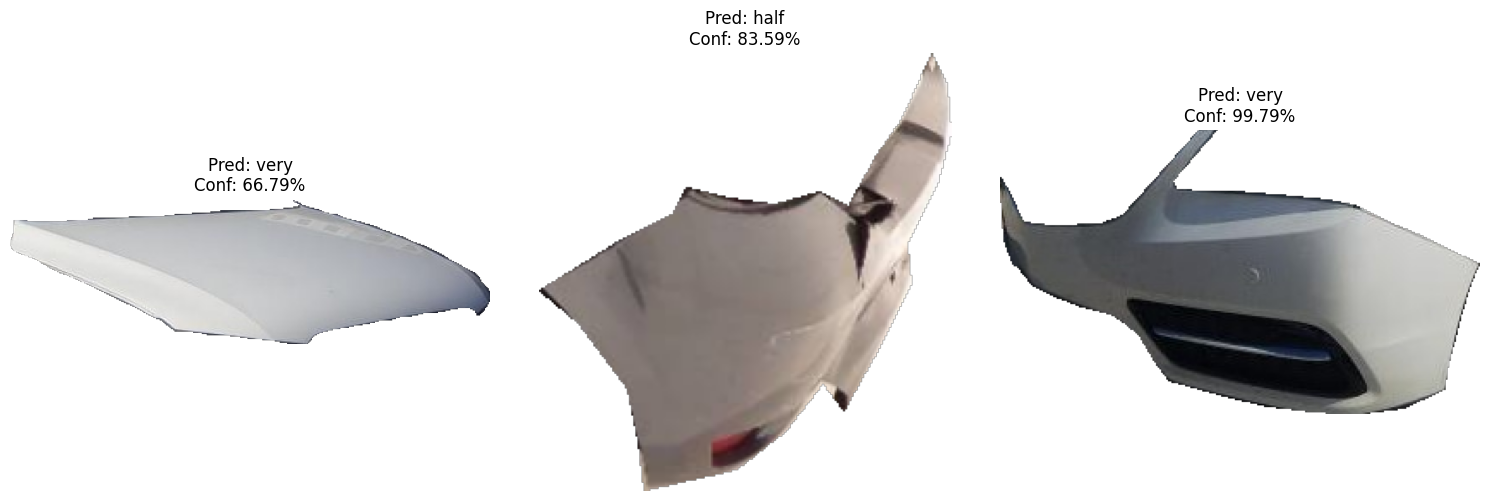

In [ ]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Configurações
MODEL_PATH = "/content/drive/MyDrive/CarDamage/ResNetDamageDoors/best_resnet_model.pth"  # Caminho para seu modelo treinado
IMAGES_PATH = "/content/test_various_parts"  # Caminho para as imagens de teste
CLASSES = ["half", "minor", "very", "without"]  # Suas classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformações (devem ser iguais às usadas no treinamento)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 1. Carregar o modelo treinado
def load_model(model_path, num_classes):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    return model

# 2. Função para fazer previsão em uma única imagem
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

    return preds.item(), probabilities.cpu().numpy()

# 3. Processar todas as imagens em um diretório
def process_images_in_folder(folder_path, model, transform, classes):
    results = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            image_path = os.path.join(folder_path, filename)
            try:
                pred_idx, probs = predict_image(image_path, model, transform)
                results.append({
                    'image': filename,
                    'prediction': classes[pred_idx],
                    'confidence': probs[pred_idx],
                    'all_confidences': {classes[i]: f"{probs[i]:.2f}%" for i in range(len(classes))}
                })
            except Exception as e:
                print(f"Erro ao processar {filename}: {str(e)}")

    return results

# 4. Visualizar resultados
def display_results(results):
    for result in results:
        print(f"\nImagem: {result['image']}")
        print(f"Predição: {result['prediction']} (Confiança: {result['confidence']:.2f}%)")
        print("Probabilidades por classe:")
        for cls, prob in result['all_confidences'].items():
            print(f"  {cls}: {prob}")

# 5. Função principal
def main():
    # Carregar modelo
    print("Carregando modelo...")
    model = load_model(MODEL_PATH, len(CLASSES))

    # Processar imagens
    print("\nProcessando imagens...")
    results = process_images_in_folder(IMAGES_PATH, model, transform, CLASSES)

    # Mostrar resultados
    print("\nResultados das inferências:")
    display_results(results)

    # Opcional: plotar algumas imagens com suas predições
    plot_sample_predictions(IMAGES_PATH, model, transform, CLASSES, num_samples=3)

# Função auxiliar para plotar exemplos
def plot_sample_predictions(folder_path, model, transform, classes, num_samples=3):
    plt.figure(figsize=(15, 5))
    valid_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for i, img_name in enumerate(valid_images[:num_samples]):
        img_path = os.path.join(folder_path, img_name)
        pred_idx, probs = predict_image(img_path, model, transform)

        plt.subplot(1, num_samples, i+1)
        image = Image.open(img_path)
        plt.imshow(image)
        plt.title(f"Pred: {classes[pred_idx]}\nConf: {probs[pred_idx]:.2f}%")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()